<a href="https://colab.research.google.com/github/portex33/MScASDF/blob/main/Scenario1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Generation


**Generate synthetic data to work on.**

This code generates random values that follow a normal districution.  The output is written to a csv file.



In [8]:
from random import seed
from random import randint
import datetime
import numpy
from numpy import random


#check if CSV file exists and delete it
import os
if os.path.exists("data1.csv"):
  os.remove("data1.csv")
  #print("file removed")

#write headings
f = open("data1.csv", "a")
f.write("week,userid,views\n")

#Generate array of number of views on a normal distribution
viewsarr = numpy.random.normal(loc=85, scale=8, size=1300).astype(int)

#Write data for 12 weeks and 100 users.
viewcount = 0
for weeks in range(12):
    for users in range(100):
        views = viewsarr[viewcount]
        f = open("data1.csv", "a")
        #convert week number to date
        d = "2021-W" + str(weeks+1)
        r = datetime.datetime.strptime(d + '-1', "%Y-W%W-%w")
        f.write(str(r) + ", " + str(users) + ", " + str(views) + "\n")
        viewcount = viewcount+1
#for some reason the last entry doesn't write unless we have the following line
f = open("data1.csv", "a")

# Visualise the Data

**Import and setup graphing libraries**

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import plotly.express as px
mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False


**Read the file and display dataframe**

In [10]:

df = pd.read_csv('data1.csv')

df


,week,userid,views
0,2021-01-04 00:00:00,0,91
1,2021-01-04 00:00:00,1,86
2,2021-01-04 00:00:00,2,88
3,2021-01-04 00:00:00,3,82
4,2021-01-04 00:00:00,4,88
...,...,...,...
1195,2021-03-22 00:00:00,95,95
1196,2021-03-22 00:00:00,96,93
1197,2021-03-22 00:00:00,97,88
1198,2021-03-22 00:00:00,98,79


**Convert week to pandas datetime type**

In [11]:
df['week'] = pd.to_datetime(df['week'])

**Generate plot of the data - views by weeks**

In [12]:
df.columns.values
df = df.rename(columns={' views': 'views'}) 

x = df.week
y = df.views
#df.plot.bar (x='week', y='views')


fig = px.scatter(df.reset_index(), x='week', y='views', title='Agent Weekly Customer Views')
fig.show()

**Seed the data with some potential anomalies and regraph**

In [13]:
df.loc[999, 'views'] = 125
df.loc[777, 'views'] = 115




fig = px.scatter(df.reset_index(), x='week', y='views', title='Agent Weekly Customer Views')
fig.show()

# Prophet Anomaly Detection

In [14]:
from fbprophet import Prophet

#Rename columns as Prophet expects columns to be named ds (timestamp) and y (data).
model_df = df.reset_index()[['week', 'views']].rename({'week':'ds', 
                                                           'views':'y'}, 
                                                          axis='columns')



**Train the Model**

In [15]:
#train with first 1000 items
train = model_df[0:599]

#test with last 200
test = model_df[600:2000]

In [17]:
model = Prophet(weekly_seasonality=True)
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**forecast future values**

In [19]:
future = model.make_future_dataframe(periods=6, freq='W-MON')
forecast = model.predict(future)

In [20]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-04,89.336783,75.353252,94.705524,89.336783,89.336783,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,0.0,0.0,0.0,84.409268
1,2021-01-11,89.285479,74.078507,95.261051,89.285479,89.285479,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,0.0,0.0,0.0,84.357964
2,2021-01-18,89.234175,73.995122,93.920612,89.234175,89.234175,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,0.0,0.0,0.0,84.306660
3,2021-01-25,89.182871,74.476816,94.867399,89.182871,89.182871,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,0.0,0.0,0.0,84.255356
4,2021-02-01,89.131569,73.859706,94.830243,89.131569,89.131569,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,0.0,0.0,0.0,84.204054
5,2021-02-08,89.079305,74.337980,93.729667,89.079305,89.079305,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,0.0,0.0,0.0,84.151790
6,2021-02-15,89.027041,73.586054,93.809733,88.814560,89.250315,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,0.0,0.0,0.0,84.099527
7,2021-02-22,88.974778,73.335812,93.521534,88.345132,89.576358,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,0.0,0.0,0.0,84.047263
8,2021-03-01,88.922514,73.674766,93.302696,87.810748,90.029635,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,0.0,0.0,0.0,83.994999
9,2021-03-08,88.870250,74.435846,94.440131,87.041634,90.607633,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,-4.927515,0.0,0.0,0.0,83.942736


In [21]:
results = pd.concat([model_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower', 'yhat_upper']]],
                    axis=1)
results

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2021-01-04,91,84.409268,75.353252,94.705524
2021-01-04,86,84.409268,75.353252,94.705524
2021-01-04,88,84.409268,75.353252,94.705524
2021-01-04,82,84.409268,75.353252,94.705524
2021-01-04,88,84.409268,75.353252,94.705524
...,...,...,...,...
2021-03-22,95,83.838208,73.405867,95.317074
2021-03-22,93,83.838208,73.405867,95.317074
2021-03-22,88,83.838208,73.405867,95.317074


**Visualise forecast trends**

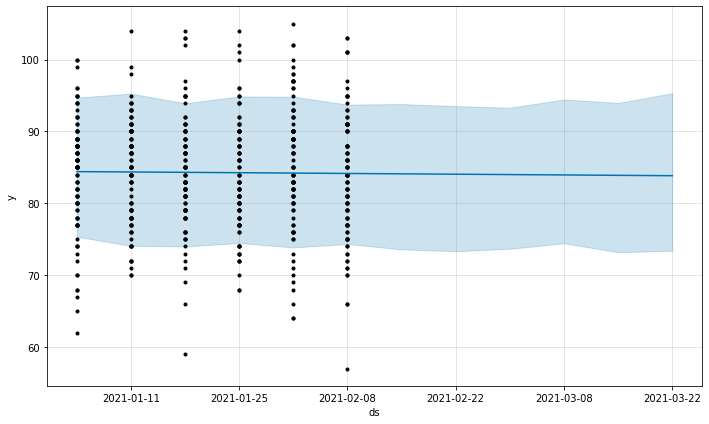

In [22]:
fig1 = model.plot(forecast)

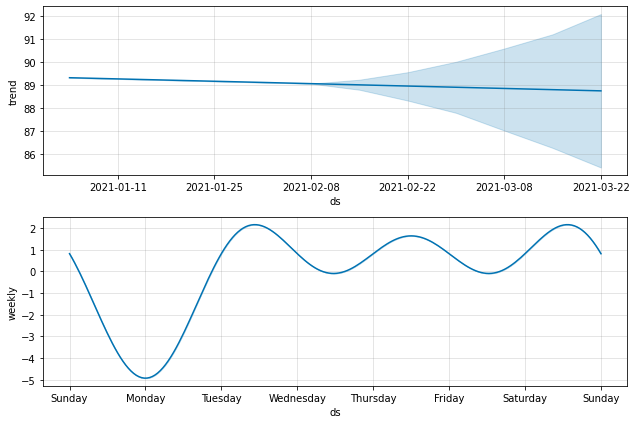

In [23]:
comp = model.plot_components(forecast)

**calculate error and uncertainty values**

In [24]:

results['error'] = results['y'] - results['yhat'] 
results['uncertainty'] = results['yhat_upper'] - results['yhat_lower']
results

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2021-01-04,91,84.409268,75.353252,94.705524,6.590732,19.352272
2021-01-04,86,84.409268,75.353252,94.705524,1.590732,19.352272
2021-01-04,88,84.409268,75.353252,94.705524,3.590732,19.352272
2021-01-04,82,84.409268,75.353252,94.705524,-2.409268,19.352272
2021-01-04,88,84.409268,75.353252,94.705524,3.590732,19.352272
...,...,...,...,...,...,...
2021-03-22,95,83.838208,73.405867,95.317074,11.161792,21.911206
2021-03-22,93,83.838208,73.405867,95.317074,9.161792,21.911206
2021-03-22,88,83.838208,73.405867,95.317074,4.161792,21.911206


In [25]:
results[results['error'].abs()>1*results['uncertainty']]

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2021-01-04,62,84.409268,75.353252,94.705524,-22.409268,19.352272
2021-01-04,65,84.409268,75.353252,94.705524,-19.409268,19.352272
2021-01-18,59,84.306660,73.995122,93.920612,-25.306660,19.925490
2021-02-08,57,84.151790,74.337980,93.729667,-27.151790,19.391687
2021-02-22,59,84.047263,73.335812,93.521534,-25.047263,20.185722
2021-02-22,105,84.047263,73.335812,93.521534,20.952737,20.185722
2021-02-22,115,84.047263,73.335812,93.521534,30.952737,20.185722
2021-03-08,125,83.942736,74.435846,94.440131,41.057264,20.004286
2021-03-15,58,83.890472,73.193870,93.967650,-25.890472,20.773780


**Find anomalies**

In [26]:
results['anomaly'] = results.apply(lambda x: 'Yes' if(np.abs(x['error'])>   x['uncertainty']) else 'No',axis=1)
results

,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly
ds,,,,,,,
2021-01-04,91,84.409268,75.353252,94.705524,6.590732,19.352272,No
2021-01-04,86,84.409268,75.353252,94.705524,1.590732,19.352272,No
2021-01-04,88,84.409268,75.353252,94.705524,3.590732,19.352272,No
2021-01-04,82,84.409268,75.353252,94.705524,-2.409268,19.352272,No
2021-01-04,88,84.409268,75.353252,94.705524,3.590732,19.352272,No
...,...,...,...,...,...,...,...
2021-03-22,95,83.838208,73.405867,95.317074,11.161792,21.911206,No
2021-03-22,93,83.838208,73.405867,95.317074,9.161792,21.911206,No
2021-03-22,88,83.838208,73.405867,95.317074,4.161792,21.911206,No


In [27]:
fig = px.scatter(results.reset_index(), x='ds', y='y', color='anomaly',labels={
                     "ds": "ds (weeks)",
                     "y": "y (views)"
                      },title='Agent Weekly Customer Views')
fig.show()

# Standard Deviation Approach

In [28]:
std_dev = results['y'].std()
print(std_dev)

mean = results['y'].mean()
print(mean)


threshold = mean + (3*std_dev)
results['anomaly2'] = results.apply(lambda x: 'Yes' if(x['y'] > threshold) else 'No',axis=1)
results


8.015905399026265
84.6175


,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly,anomaly2
ds,,,,,,,,
2021-01-04,91,84.409268,75.353252,94.705524,6.590732,19.352272,No,No
2021-01-04,86,84.409268,75.353252,94.705524,1.590732,19.352272,No,No
2021-01-04,88,84.409268,75.353252,94.705524,3.590732,19.352272,No,No
2021-01-04,82,84.409268,75.353252,94.705524,-2.409268,19.352272,No,No
2021-01-04,88,84.409268,75.353252,94.705524,3.590732,19.352272,No,No
...,...,...,...,...,...,...,...,...
2021-03-22,95,83.838208,73.405867,95.317074,11.161792,21.911206,No,No
2021-03-22,93,83.838208,73.405867,95.317074,9.161792,21.911206,No,No
2021-03-22,88,83.838208,73.405867,95.317074,4.161792,21.911206,No,No


In [29]:
fig = px.scatter(results.reset_index(), x='ds', y='y', color='anomaly2',labels={
                     "ds": "ds (weeks)",
                     "y": "y (views)"
                      },title='Agent Weekly Customer Views')
fig.show()

# Model Refinement

**Prophet Model**


In [30]:
results['anomaly'] = results.apply(lambda x: 'Yes' if(np.abs(x['error'])> 1.485 *  x['uncertainty']) else 'No',axis=1)
results

,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly,anomaly2
ds,,,,,,,,
2021-01-04,91,84.409268,75.353252,94.705524,6.590732,19.352272,No,No
2021-01-04,86,84.409268,75.353252,94.705524,1.590732,19.352272,No,No
2021-01-04,88,84.409268,75.353252,94.705524,3.590732,19.352272,No,No
2021-01-04,82,84.409268,75.353252,94.705524,-2.409268,19.352272,No,No
2021-01-04,88,84.409268,75.353252,94.705524,3.590732,19.352272,No,No
...,...,...,...,...,...,...,...,...
2021-03-22,95,83.838208,73.405867,95.317074,11.161792,21.911206,No,No
2021-03-22,93,83.838208,73.405867,95.317074,9.161792,21.911206,No,No
2021-03-22,88,83.838208,73.405867,95.317074,4.161792,21.911206,No,No


In [31]:
fig = px.scatter(results.reset_index(), x='ds', y='y', color='anomaly',labels={"ds": "ds (weeks)","y": "y (views)"},title='Agent Weekly Customer Views')
fig.show()

**Standard Deviation Model**

In [32]:
std_dev = results['y'].std()
print(std_dev)

mean = results['y'].mean()
print(mean)


threshold = mean + (3.5*std_dev)
results['anomaly2'] = results.apply(lambda x: 'Yes' if(x['y'] > threshold) else 'No',axis=1)
results


8.015905399026265
84.6175


,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly,anomaly2
ds,,,,,,,,
2021-01-04,91,84.409268,75.353252,94.705524,6.590732,19.352272,No,No
2021-01-04,86,84.409268,75.353252,94.705524,1.590732,19.352272,No,No
2021-01-04,88,84.409268,75.353252,94.705524,3.590732,19.352272,No,No
2021-01-04,82,84.409268,75.353252,94.705524,-2.409268,19.352272,No,No
2021-01-04,88,84.409268,75.353252,94.705524,3.590732,19.352272,No,No
...,...,...,...,...,...,...,...,...
2021-03-22,95,83.838208,73.405867,95.317074,11.161792,21.911206,No,No
2021-03-22,93,83.838208,73.405867,95.317074,9.161792,21.911206,No,No
2021-03-22,88,83.838208,73.405867,95.317074,4.161792,21.911206,No,No


In [33]:
fig = px.scatter(results.reset_index(), x='ds', y='y', color='anomaly2',labels={"ds": "ds (weeks)","y": "y (views)"},title='Agent Weekly Customer Views')
fig.show()